In [169]:
import pandas as pd
import numpy as np
import config
import os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

In [170]:
pip install snowflake-connector-python[pandas]

Note: you may need to restart the kernel to use updated packages.


In [171]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [172]:
# The Snowflake Connector library.
import snowflake.connector as snow
from snowflake.connector.pandas_tools import write_pandas

In [173]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

In [174]:
# Set up the Snowflake connection
user = config.credentials['USERNAME']
password = config.credentials['PASSWORD']
account = 'PCA67849'
warehouse = config.credentials['WAREHOUSE']

conn = snow.connect(
    user=user,
    password=password,
    account=account,
    warehouse=warehouse, 
    database='',       # The database you want to use
    schema='' 
)

In [175]:
# Get your list of skills including Category Name
skills_query = """
SELECT "Skill", "Category Name" 
FROM TEMPORARY_DATA.JNANIA."ADE_LC_skills_v5_2025_03_10"
"""
skills_df = pd.read_sql(skills_query, conn)
skills = skills_df["Skill"].tolist()

# Create a dictionary to map skills to their categories
skill_to_category = dict(zip(skills_df["Skill"], skills_df["Category Name"]))

C:\Users\JennyDuan\AppData\Local\Temp\ipykernel_15952\359130624.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  skills_df = pd.read_sql(skills_query, conn)


In [176]:
skill_to_category

{'Critical Thinking': 'Adaptive & Reflective Rationality',
 'Creativity': 'Adaptive & Reflective Rationality',
 'Curiosity': 'Adaptive & Reflective Rationality',
 'Analytical Thinking': 'Adaptive & Reflective Rationality',
 'Creative Thinking': 'Adaptive & Reflective Rationality',
 'Intellectual Curiosity': 'Adaptive & Reflective Rationality',
 'Mental Concentration': 'Adaptive & Reflective Rationality',
 'Growth Mindedness': 'Adaptive & Reflective Rationality',
 'Ideation': 'Adaptive & Reflective Rationality',
 'Self-Awareness': 'Adaptive & Reflective Rationality',
 'Independent Thinking': 'Adaptive & Reflective Rationality',
 'Deductive Reasoning': 'Adaptive & Reflective Rationality',
 'Open Mindset': 'Adaptive & Reflective Rationality',
 'Humility': 'Adaptive & Reflective Rationality',
 'Intellectual Humility': 'Adaptive & Reflective Rationality',
 'Fact Checking': 'Adaptive & Reflective Rationality',
 'Logical Reasoning': 'Adaptive & Reflective Rationality',
 'Self-Regulation': 'Ad

In [ ]:
# Query to get skill-occupation relationships with the additional filters
skill_occ_query = f"""
WITH base_postings AS (
    SELECT 
        ID,
        SOC_2021_5,
        SOC_2021_5_NAME,
        SOC_2021_2,
        SOC_2021_2_NAME,
        YEAR(POSTED) AS YEAR
    FROM BGI_POSTINGS_BACKUPS.FEB_25.US_POSTINGS
    WHERE YEAR(POSTED) BETWEEN 2022 AND 2024
        AND SOC_2021_5 IS NOT NULL
        AND SOC_2021_5 != '99-9999.00'
        AND ARRAY_SIZE(SKILLS) > 0
        AND (SALARY_TO > 0 OR SALARY > 0 OR SALARY_FROM > 0)
        AND ARRAY_CONTAINS('Company'::VARIANT, SOURCE_TYPES)
        AND IS_INTERNSHIP = FALSE
        AND COMPANY_IS_STAFFING = FALSE
        -- AND SOC_2021_2 IN ('11-0000', '13-0000', '15-0000', '17-0000', '19-0000')
),
soc5_counts AS (
    SELECT 
        SOC_2021_5, 
        COUNT(DISTINCT ID) AS soc5_post_count
    FROM base_postings
    GROUP BY SOC_2021_5
    HAVING COUNT(DISTINCT ID) >= 500
),
soc2_counts AS (
    SELECT 
        SOC_2021_2,
        COUNT(DISTINCT ID) AS soc2_post_count
    FROM base_postings
    GROUP BY SOC_2021_2
)
SELECT 
    bp.SOC_2021_5,
    bp.SOC_2021_5_NAME,
    bp.SOC_2021_2,
    bp.SOC_2021_2_NAME,
    sc5.soc5_post_count,
    sc2.soc2_post_count,
    ps.SKILL_NAME,
    COUNT(DISTINCT bp.ID) AS N
FROM base_postings bp
JOIN soc5_counts sc5 ON bp.SOC_2021_5 = sc5.SOC_2021_5
JOIN soc2_counts sc2 ON bp.SOC_2021_2 = sc2.SOC_2021_2
JOIN BGI_POSTINGS_BACKUPS.FEB_25.US_POSTINGS_SKILLS ps ON bp.ID = ps.ID
WHERE ps.SKILL_NAME IN ({', '.join([f"'{skill}'" for skill in skills])})
GROUP BY bp.SOC_2021_5, bp.SOC_2021_5_NAME, bp.SOC_2021_2, bp.SOC_2021_2_NAME, 
         sc5.soc5_post_count, sc2.soc2_post_count, ps.SKILL_NAME
"""

# Execute query and get data
occ_skills = pd.read_sql(skill_occ_query, conn)

C:\Users\JennyDuan\AppData\Local\Temp\ipykernel_15952\2872172613.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  occ_skills = pd.read_sql(skill_occ_query, conn)


In [178]:
# Execute query and get data (same as before)
occ_skills = pd.read_sql(skill_occ_query, conn)

# Add category column after querying
occ_skills['SKILL_CATEGORY'] = occ_skills['SKILL_NAME'].map(skill_to_category)

C:\Users\JennyDuan\AppData\Local\Temp\ipykernel_15952\1729397295.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  occ_skills = pd.read_sql(skill_occ_query, conn)


In [179]:
# Ensure all column names are uppercase from the beginning
occ_skills.columns = [col.upper() for col in occ_skills.columns]

In [180]:
occ_skills

,SOC_2021_5,SOC_2021_5_NAME,SOC_2021_2,SOC_2021_2_NAME,SOC5_POST_COUNT,SOC2_POST_COUNT,SKILL_NAME,N,SKILL_CATEGORY
0,15-1241,Computer Network Architects,15-0000,Computer and Mathematical Occupations,15385,364242,Fact Checking,1,Adaptive & Reflective Rationality
1,17-2151,"Mining and Geological Engineers, Including Min...",17-0000,Architecture and Engineering Occupations,700,138185,Active Listening,1,Adaptive & Reflective Rationality
2,25-4022,Librarians and Media Collections Specialists,25-0000,Educational Instruction and Library Occupations,973,66240,Risk Mindset,1,Quantitative & Statistical Reasoning
3,11-9121,Natural Sciences Managers,11-0000,Management Occupations,7099,630525,Confidence Intervals,1,Quantitative & Statistical Reasoning
4,33-2021,Fire Inspectors and Investigators,33-0000,Protective Service Occupations,611,129325,Risk Analysis,1,Quantitative & Statistical Reasoning
...,...,...,...,...,...,...,...,...,...
20088,17-2141,Mechanical Engineers,17-0000,Architecture and Engineering Occupations,19891,138185,Self-Regulation,2,Adaptive & Reflective Rationality
20089,13-2099,"Financial Specialists, All Other",13-0000,Business and Financial Operations Occupations,2456,367186,Risk Awareness,2,Quantitative & Statistical Reasoning
20090,29-1128,Exercise Physiologists,29-0000,Healthcare Practitioners and Technical Occupat...,763,634046,Mental Concentration,2,Adaptive & Reflective Rationality
20091,11-3071,"Transportation, Storage, and Distribution Mana...",11-0000,Management Occupations,28613,630525,Secondary Source Information,2,Structured & Systematic Decision-Making Process


In [181]:
# Calculate metrics in Python as in the original code
# Calculate skill share within each occupation
occ_skills_by_onet = occ_skills.groupby('SOC_2021_5')
occ_skills['SKILL_SHARE'] = occ_skills.apply(
    lambda x: x['N'] / occ_skills_by_onet.get_group(x['SOC_2021_5'])['N'].sum(),
    axis=1
)
occ_skills['SKILL_RATE'] = occ_skills['N'] / occ_skills['SOC5_POST_COUNT']


In [182]:
# Filter low-frequency skills
occ_skills = occ_skills[(occ_skills['N'] > 50) | (occ_skills['SKILL_RATE'] > 0.02)]

In [183]:
occ_skills

,SOC_2021_5,SOC_2021_5_NAME,SOC_2021_2,SOC_2021_2_NAME,SOC5_POST_COUNT,SOC2_POST_COUNT,SKILL_NAME,N,SKILL_CATEGORY,SKILL_SHARE,SKILL_RATE
394,53-6031,Automotive and Watercraft Service Attendants,53-0000,Transportation and Material Moving Occupations,6902,348463,Verbal Communication Skills,648,Adaptive & Reflective Rationality,0.149000,0.093886
395,49-9041,Industrial Machinery Mechanics,49-0000,"Installation, Maintenance, and Repair Occupations",7778,262796,Problem Solving,1165,Structured & Systematic Decision-Making Process,0.166571,0.149781
396,99-9999,Unclassified Occupation,99-0000,Unclassified Occupation,206879,206879,Data Analysis,12926,Quantitative & Statistical Reasoning,0.058837,0.062481
397,15-1299,"Computer Occupations, All Other",15-0000,Computer and Mathematical Occupations,90829,364242,Data Analysis,7668,Quantitative & Statistical Reasoning,0.063148,0.084422
398,17-2141,Mechanical Engineers,17-0000,Architecture and Engineering Occupations,19891,138185,Problem Solving,4401,Structured & Systematic Decision-Making Process,0.207340,0.221256
...,...,...,...,...,...,...,...,...,...,...,...
19504,13-2031,Budget Analysts,13-0000,Business and Financial Operations Occupations,825,367186,Resilience,17,Adaptive & Reflective Rationality,0.013721,0.020606
19518,19-1012,Food Scientists and Technologists,19-0000,"Life, Physical, and Social Science Occupations",543,64510,Resilience,19,Adaptive & Reflective Rationality,0.027338,0.034991
19543,15-2041,Statisticians,15-0000,Computer and Mathematical Occupations,1347,364242,Creativity,34,Adaptive & Reflective Rationality,0.011307,0.025241
19610,27-1019,"Artists and Related Workers, All Other",27-0000,"Arts, Design, Entertainment, Sports, and Media...",537,123478,Critical Thinking,11,Adaptive & Reflective Rationality,0.039427,0.020484


# Now aggregate soc6 skill level data to soc2 level

In [184]:
# Calculate skill total and count of occupations with each skill
skill_totals = occ_skills.groupby('SKILL_NAME')['N'].sum().reset_index(name='SKILL_TOTAL')
skill_in_occs = occ_skills.groupby('SKILL_NAME').size().reset_index(name='SKILL_IN_OCCS_COUNT')

# Merge these back to the main dataframe - ensure we keep all our columns during merges
occ_skills = pd.merge(occ_skills, skill_totals, on='SKILL_NAME', how='left')
occ_skills = pd.merge(occ_skills, skill_in_occs, on='SKILL_NAME', how='left')

In [185]:
occ_skills

,SOC_2021_5,SOC_2021_5_NAME,SOC_2021_2,SOC_2021_2_NAME,SOC5_POST_COUNT,SOC2_POST_COUNT,SKILL_NAME,N,SKILL_CATEGORY,SKILL_SHARE,SKILL_RATE,SKILL_TOTAL,SKILL_IN_OCCS_COUNT
0,53-6031,Automotive and Watercraft Service Attendants,53-0000,Transportation and Material Moving Occupations,6902,348463,Verbal Communication Skills,648,Adaptive & Reflective Rationality,0.149000,0.093886,414618,424
1,49-9041,Industrial Machinery Mechanics,49-0000,"Installation, Maintenance, and Repair Occupations",7778,262796,Problem Solving,1165,Structured & Systematic Decision-Making Process,0.166571,0.149781,808208,457
2,99-9999,Unclassified Occupation,99-0000,Unclassified Occupation,206879,206879,Data Analysis,12926,Quantitative & Statistical Reasoning,0.058837,0.062481,183896,250
3,15-1299,"Computer Occupations, All Other",15-0000,Computer and Mathematical Occupations,90829,364242,Data Analysis,7668,Quantitative & Statistical Reasoning,0.063148,0.084422,183896,250
4,17-2141,Mechanical Engineers,17-0000,Architecture and Engineering Occupations,19891,138185,Problem Solving,4401,Structured & Systematic Decision-Making Process,0.207340,0.221256,808208,457
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,13-2031,Budget Analysts,13-0000,Business and Financial Operations Occupations,825,367186,Resilience,17,Adaptive & Reflective Rationality,0.013721,0.020606,60755,168
6460,19-1012,Food Scientists and Technologists,19-0000,"Life, Physical, and Social Science Occupations",543,64510,Resilience,19,Adaptive & Reflective Rationality,0.027338,0.034991,60755,168
6461,15-2041,Statisticians,15-0000,Computer and Mathematical Occupations,1347,364242,Creativity,34,Adaptive & Reflective Rationality,0.011307,0.025241,60111,200
6462,27-1019,"Artists and Related Workers, All Other",27-0000,"Arts, Design, Entertainment, Sports, and Media...",537,123478,Critical Thinking,11,Adaptive & Reflective Rationality,0.039427,0.020484,176784,317


In [186]:
# Add small sample flag for Skill Posting Count at the soc 6 digit level
occ_skills['SMALL_SAMPLE_FLAG_SKILL_TOTAL'] = occ_skills['SKILL_TOTAL'] < 500


In [187]:
# Create SOC2 level dataset
soc2_skills = occ_skills.copy()


In [188]:

# Aggregate for SOC2 groups
soc2_group = soc2_skills.groupby(['SOC_2021_2', 'SOC_2021_2_NAME', 'SKILL_NAME', 'SKILL_CATEGORY'])
soc2_importance = soc2_group.agg({
    'N': 'sum',
    'SOC2_POST_COUNT': 'first',  # Use the correct SOC2 level count
    'SKILL_TOTAL': 'first',  # Already calculated, just keep the first value
    'SKILL_IN_OCCS_COUNT': 'first'  # Already calculated, just keep the first value
}).reset_index()


In [189]:
soc2_importance
# Calculate SOC2 level metrics with the correct post count
soc2_by_group = soc2_importance.groupby('SOC_2021_2')
soc2_importance['SKILL_SHARE'] = soc2_importance.apply(
    lambda x: x['N'] / soc2_by_group.get_group(x['SOC_2021_2'])['N'].sum(),
    axis=1
)
soc2_importance['SKILL_RATE'] = soc2_importance['N'] / soc2_importance['SOC2_POST_COUNT']

In [190]:
# Add small sample flag
soc2_importance['SMALL_SAMPLE_FLAG_SKILL_TOTAL'] = soc2_importance['SKILL_TOTAL'] < 500

# Load and merge bls data with skills data

In [191]:
# Step 1: Load BLS projections data
print("Loading BLS projections data...")
bls_file = "C:/Users/JennyDuan/OneDrive - Burning Glass Institute/BGI Projects/Alliance Decision Edu/occupation BLS Projections.xlsx" # edit this path for code review
bls_data = pd.read_excel(bls_file)

Loading BLS projections data...


In [192]:
# Set exact column names from the file
code_col = '2023 National Employment Matrix code'
title_col = '2023 National Employment Matrix title'
emp_col = 'Employment, 2023'
pct_change_col = 'Employment change, percent, 2023–33'

In [193]:
# Create SOC2 codes by taking first 2 digits of SOC6 and adding -0000
bls_data['soc2'] = bls_data[code_col].str.extract(r'(\d{2})').fillna('') + '-0000'

# Convert employment to numeric (handle thousands format if needed)
bls_data[emp_col] = pd.to_numeric(bls_data[emp_col], errors='coerce')

# Convert percent change to numeric if needed
bls_data[pct_change_col] = pd.to_numeric(bls_data[pct_change_col], errors='coerce')

# Filter out rows with missing key data
bls_data = bls_data.dropna(subset=['soc2', emp_col, pct_change_col])

# Manual dictionary of standard SOC2 names
standard_soc2_names = {
    '11-0000': 'Management Occupations',
    '13-0000': 'Business and Financial Operations Occupations',
    '15-0000': 'Computer and Mathematical Occupations',
    '17-0000': 'Architecture and Engineering Occupations',
    '19-0000': 'Life, Physical, and Social Science Occupations',
    '21-0000': 'Community and Social Service Occupations',
    '23-0000': 'Legal Occupations',
    '25-0000': 'Educational Instruction and Library Occupations',
    '27-0000': 'Arts, Design, Entertainment, Sports, and Media Occupations',
    '29-0000': 'Healthcare Practitioners and Technical Occupations',
    '31-0000': 'Healthcare Support Occupations',
    '33-0000': 'Protective Service Occupations',
    '35-0000': 'Food Preparation and Serving Related Occupations',
    '37-0000': 'Building and Grounds Cleaning and Maintenance Occupations',
    '39-0000': 'Personal Care and Service Occupations',
    '41-0000': 'Sales and Related Occupations',
    '43-0000': 'Office and Administrative Support Occupations',
    '45-0000': 'Farming, Fishing, and Forestry Occupations',
    '47-0000': 'Construction and Extraction Occupations',
    '49-0000': 'Installation, Maintenance, and Repair Occupations',
    '51-0000': 'Production Occupations',
    '53-0000': 'Transportation and Material Moving Occupations',
    '55-0000': 'Military Specific Occupations'
}

# Prepare empty list for aggregation results
soc2_results = []

In [194]:
# Aggregate manually to avoid reset_index issues
for soc2, group in bls_data.groupby('soc2'):
    total_emp = group[emp_col].sum()
    # Calculate weighted average growth
    weighted_growth = np.average(group[pct_change_col], weights=group[emp_col]) if total_emp > 0 else 0
    
    # Get the standard SOC2 name from our mapping
    soc2_name = standard_soc2_names.get(soc2, f"SOC {soc2[:2]} Occupations")
    
    soc2_results.append({
        'soc2': soc2,
        'soc2_name': soc2_name,  # Use the standard name from our manual mapping
        'total_2023_bls_employment': total_emp,
        'weighted_10yr_growth_pct': weighted_growth,
        'min_growth': group[pct_change_col].min(),
        'max_growth': group[pct_change_col].max(),
        'occupations_count': len(group)
    })

# Convert results to DataFrame
bls_soc2_data = pd.DataFrame(soc2_results)

In [195]:
# Clean SOC2 codes to match your format (with and without hyphens)
bls_soc2_data['soc2_clean'] = bls_soc2_data['soc2'].str.replace('-', '')
bls_soc2_data['soc2_with_hyphen'] = bls_soc2_data['soc2']

print(f"Aggregated {len(bls_data)} SOC6 occupations to {len(bls_soc2_data)} SOC2 groups")

Aggregated 832 SOC6 occupations to 22 SOC2 groups


In [196]:
soc2_importance

,SOC_2021_2,SOC_2021_2_NAME,SKILL_NAME,SKILL_CATEGORY,N,SOC2_POST_COUNT,SKILL_TOTAL,SKILL_IN_OCCS_COUNT,SKILL_SHARE,SKILL_RATE,SMALL_SAMPLE_FLAG_SKILL_TOTAL
0,11-0000,Management Occupations,Active Listening,Adaptive & Reflective Rationality,3871,630525,26680,116,0.005623,0.006139,False
1,11-0000,Management Occupations,Adaptability,Adaptive & Reflective Rationality,12875,630525,93265,226,0.018701,0.020419,False
2,11-0000,Management Occupations,Analytical Thinking,Adaptive & Reflective Rationality,4293,630525,21601,94,0.006235,0.006809,False
3,11-0000,Management Occupations,Analytics,Quantitative & Statistical Reasoning,10176,630525,30709,64,0.014780,0.016139,False
4,11-0000,Management Occupations,Collaboration,Adaptive & Reflective Rationality,25611,630525,116071,237,0.037199,0.040619,False
...,...,...,...,...,...,...,...,...,...,...,...
828,99-0000,Unclassified Occupation,Strategic Decision Making,Structured & Systematic Decision-Making Process,850,206879,13582,51,0.003882,0.004109,False
829,99-0000,Unclassified Occupation,Strategic Thinking,Structured & Systematic Decision-Making Process,3783,206879,46083,111,0.017276,0.018286,False
830,99-0000,Unclassified Occupation,Systems Thinking,Structured & Systematic Decision-Making Process,323,206879,3398,21,0.001475,0.001561,False
831,99-0000,Unclassified Occupation,Troubleshooting (Problem Solving),Structured & Systematic Decision-Making Process,16056,206879,328914,341,0.073326,0.077611,False


In [197]:
# Step 2: Prepare skill data
print("\nPreparing skill data...")
# Make a copy to avoid modifying the original
skill_data = soc2_importance.copy()
soc_col = 'SOC_2021_2'


# Ensure SOC codes are formatted consistently
skill_data['soc2_clean'] = skill_data[soc_col].str.replace('-', '')


Preparing skill data...


In [198]:
# Apply N > 50 filter if the column exists
if 'N' in skill_data.columns:
    print(f"Filtering for N > 50 (original shape: {skill_data.shape})")
    skill_data = skill_data[skill_data['N'] > 50]
    print(f"After filtering: {skill_data.shape}")
    

Filtering for N > 50 (original shape: (833, 12))
After filtering: (818, 12)


In [199]:
# Apply small sample filter if it exists
if 'SMALL_SAMPLE_FLAG_SKILL_TOTAL' in skill_data.columns:
    print("Filtering out small sample skills")
    skill_data = skill_data[skill_data['SMALL_SAMPLE_FLAG_SKILL_TOTAL'] == False]

Filtering out small sample skills


In [200]:
skill_data

,SOC_2021_2,SOC_2021_2_NAME,SKILL_NAME,SKILL_CATEGORY,N,SOC2_POST_COUNT,SKILL_TOTAL,SKILL_IN_OCCS_COUNT,SKILL_SHARE,SKILL_RATE,SMALL_SAMPLE_FLAG_SKILL_TOTAL,soc2_clean
0,11-0000,Management Occupations,Active Listening,Adaptive & Reflective Rationality,3871,630525,26680,116,0.005623,0.006139,False,110000
1,11-0000,Management Occupations,Adaptability,Adaptive & Reflective Rationality,12875,630525,93265,226,0.018701,0.020419,False,110000
2,11-0000,Management Occupations,Analytical Thinking,Adaptive & Reflective Rationality,4293,630525,21601,94,0.006235,0.006809,False,110000
3,11-0000,Management Occupations,Analytics,Quantitative & Statistical Reasoning,10176,630525,30709,64,0.014780,0.016139,False,110000
4,11-0000,Management Occupations,Collaboration,Adaptive & Reflective Rationality,25611,630525,116071,237,0.037199,0.040619,False,110000
...,...,...,...,...,...,...,...,...,...,...,...,...
828,99-0000,Unclassified Occupation,Strategic Decision Making,Structured & Systematic Decision-Making Process,850,206879,13582,51,0.003882,0.004109,False,990000
829,99-0000,Unclassified Occupation,Strategic Thinking,Structured & Systematic Decision-Making Process,3783,206879,46083,111,0.017276,0.018286,False,990000
830,99-0000,Unclassified Occupation,Systems Thinking,Structured & Systematic Decision-Making Process,323,206879,3398,21,0.001475,0.001561,False,990000
831,99-0000,Unclassified Occupation,Troubleshooting (Problem Solving),Structured & Systematic Decision-Making Process,16056,206879,328914,341,0.073326,0.077611,False,990000


In [201]:
# Step 3: Merge skill data with BLS projections
print("\nMerging skill data with BLS projections at SOC2 level...")

# Merge skill data with BLS projections
merged_data = skill_data.merge(
    bls_soc2_data[['soc2_clean', 'weighted_10yr_growth_pct', 'total_2023_bls_employment', 'soc2_name']],
    on='soc2_clean',
    how='left'
)

# Check how many records matched
matched_count = merged_data['weighted_10yr_growth_pct'].notna().sum()
total_count = len(merged_data)
match_percentage = matched_count / total_count * 100 if total_count > 0 else 0

print(f"Matched {matched_count} out of {total_count} rows with BLS projections ({match_percentage:.1f}%)")

# Drop rows with missing growth data
merged_data = merged_data.dropna(subset=['weighted_10yr_growth_pct'])

print(f"Final dataset shape after dropping unmatched rows: {merged_data.shape}")


Merging skill data with BLS projections at SOC2 level...
Matched 726 out of 785 rows with BLS projections (92.5%)
Final dataset shape after dropping unmatched rows: (726, 15)


In [202]:
# Drop rows with missing growth data
merged_data = merged_data.dropna(subset=['weighted_10yr_growth_pct'])

print(f"Final dataset shape after dropping unmatched rows: {merged_data.shape}")

# Optional: Display the SOC2 codes and their names
print("\nSOC2 Codes and their standard names:")
for index, row in bls_soc2_data.iterrows():
    print(f"{row['soc2']}: {row['soc2_name']}")

# Save merged data to CSV if needed
# output_dir = 'merged_data'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# merged_data.to_csv(f"{output_dir}/merged_skills_growth_data.csv", index=False)
# print(f"Saved merged data to {output_dir}/merged_skills_growth_data.csv")

Final dataset shape after dropping unmatched rows: (726, 15)

SOC2 Codes and their standard names:
11-0000: Management Occupations
13-0000: Business and Financial Operations Occupations
15-0000: Computer and Mathematical Occupations
17-0000: Architecture and Engineering Occupations
19-0000: Life, Physical, and Social Science Occupations
21-0000: Community and Social Service Occupations
23-0000: Legal Occupations
25-0000: Educational Instruction and Library Occupations
27-0000: Arts, Design, Entertainment, Sports, and Media Occupations
29-0000: Healthcare Practitioners and Technical Occupations
31-0000: Healthcare Support Occupations
33-0000: Protective Service Occupations
35-0000: Food Preparation and Serving Related Occupations
37-0000: Building and Grounds Cleaning and Maintenance Occupations
39-0000: Personal Care and Service Occupations
41-0000: Sales and Related Occupations
43-0000: Office and Administrative Support Occupations
45-0000: Farming, Fishing, and Forestry Occupations
4

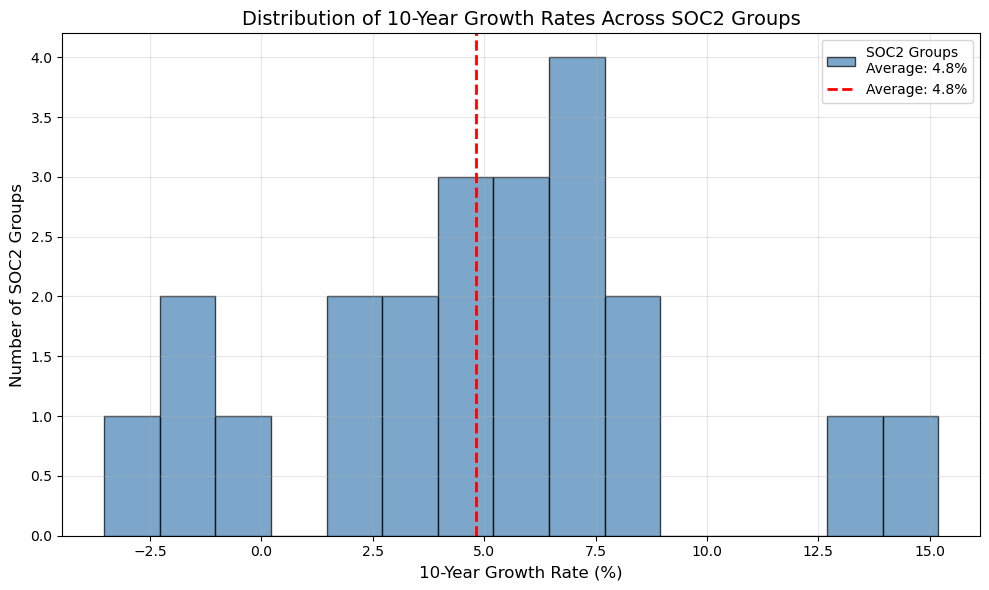

<Figure size 640x480 with 0 Axes>

In [203]:
# This script shows a simple distribution of growth rates across SOC2 groups to see what the average growth rate looks like

# Calculate the average growth rate
average_growth = bls_soc2_data['weighted_10yr_growth_pct'].mean()

# Create a simple histogram of growth rates
plt.figure(figsize=(10, 6))
plt.hist(bls_soc2_data['weighted_10yr_growth_pct'], bins=15, alpha=0.7, color='steelblue', 
         edgecolor='black', label=f'SOC2 Groups\nAverage: {average_growth:.1f}%')

# Add a vertical line for the average
plt.axvline(average_growth, color='red', linestyle='dashed', linewidth=2, 
            label=f'Average: {average_growth:.1f}%')

# Add labels and title
plt.xlabel('10-Year Growth Rate (%)', fontsize=12)
plt.ylabel('Number of SOC2 Groups', fontsize=12)
plt.title('Distribution of 10-Year Growth Rates Across SOC2 Groups', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Optional: Save the plot
plt.savefig('growth_rate_distribution.png', dpi=300, bbox_inches='tight')

In [204]:
merged_data

,SOC_2021_2,SOC_2021_2_NAME,SKILL_NAME,SKILL_CATEGORY,N,SOC2_POST_COUNT,SKILL_TOTAL,SKILL_IN_OCCS_COUNT,SKILL_SHARE,SKILL_RATE,SMALL_SAMPLE_FLAG_SKILL_TOTAL,soc2_clean,weighted_10yr_growth_pct,total_2023_bls_employment,soc2_name
0,11-0000,Management Occupations,Active Listening,Adaptive & Reflective Rationality,3871,630525,26680,116,0.005623,0.006139,False,110000,7.272807,13181.2,Management Occupations
1,11-0000,Management Occupations,Adaptability,Adaptive & Reflective Rationality,12875,630525,93265,226,0.018701,0.020419,False,110000,7.272807,13181.2,Management Occupations
2,11-0000,Management Occupations,Analytical Thinking,Adaptive & Reflective Rationality,4293,630525,21601,94,0.006235,0.006809,False,110000,7.272807,13181.2,Management Occupations
3,11-0000,Management Occupations,Analytics,Quantitative & Statistical Reasoning,10176,630525,30709,64,0.014780,0.016139,False,110000,7.272807,13181.2,Management Occupations
4,11-0000,Management Occupations,Collaboration,Adaptive & Reflective Rationality,25611,630525,116071,237,0.037199,0.040619,False,110000,7.272807,13181.2,Management Occupations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,53-0000,Transportation and Material Moving Occupations,Self-Discipline,Adaptive & Reflective Rationality,1305,348463,48393,169,0.014289,0.003745,False,530000,4.786431,14315.1,Transportation and Material Moving Occupations
722,53-0000,Transportation and Material Moving Occupations,Self-Motivation,Adaptive & Reflective Rationality,11845,348463,412367,421,0.129692,0.033992,False,530000,4.786431,14315.1,Transportation and Material Moving Occupations
723,53-0000,Transportation and Material Moving Occupations,Strategic Thinking,Structured & Systematic Decision-Making Process,418,348463,46083,111,0.004577,0.001200,False,530000,4.786431,14315.1,Transportation and Material Moving Occupations
724,53-0000,Transportation and Material Moving Occupations,Troubleshooting (Problem Solving),Structured & Systematic Decision-Making Process,6951,348463,328914,341,0.076107,0.019948,False,530000,4.786431,14315.1,Transportation and Material Moving Occupations


In [205]:
## Occupatiuon growth rate and decision skills

# Define column names
skill_col = 'SKILL_NAME'
category_col = 'SKILL_CATEGORY' 
pct_change_col = 'weighted_10yr_growth_pct'

# Calculate growth statistics for all skills
print("Calculating growth statistics for skills...")
skill_growth = merged_data.groupby(skill_col).agg({
    pct_change_col: 'mean',
    category_col: lambda x: x.mode().iloc[0] if not x.empty else None,
    'N': 'sum'  # Sum of mentions across all occupations
}).reset_index()


Calculating growth statistics for skills...


In [206]:
# Rename the N column for clarity
skill_growth = skill_growth.rename(columns={'N': 'Total_Skill_Mentions'})

In [207]:
skill_growth

,SKILL_NAME,weighted_10yr_growth_pct,SKILL_CATEGORY,Total_Skill_Mentions
0,Active Listening,4.928574,Adaptive & Reflective Rationality,25359
1,Adaptability,5.140653,Adaptive & Reflective Rationality,86825
2,Analytical Thinking,4.686750,Adaptive & Reflective Rationality,20041
3,Analytics,3.154926,Quantitative & Statistical Reasoning,29141
4,Collaboration,5.115632,Adaptive & Reflective Rationality,109274
5,Complex Problem Solving,5.680334,Structured & Systematic Decision-Making Process,17026
6,Consensus Decision Making,5.358695,Structured & Systematic Decision-Making Process,2183
7,Cost Benefit Analysis,5.065917,Quantitative & Statistical Reasoning,5803
8,Creative Problem Solving,5.365665,Structured & Systematic Decision-Making Process,20122
9,Creative Thinking,4.676941,Adaptive & Reflective Rationality,17038


Median growth rate across all skills: 5.05%
Found 28 high growth skills (above median 5.05%)
Saved growth rate data to CSV files: 'all_skills_growth_rates.csv' and 'high_growth_skills.csv'


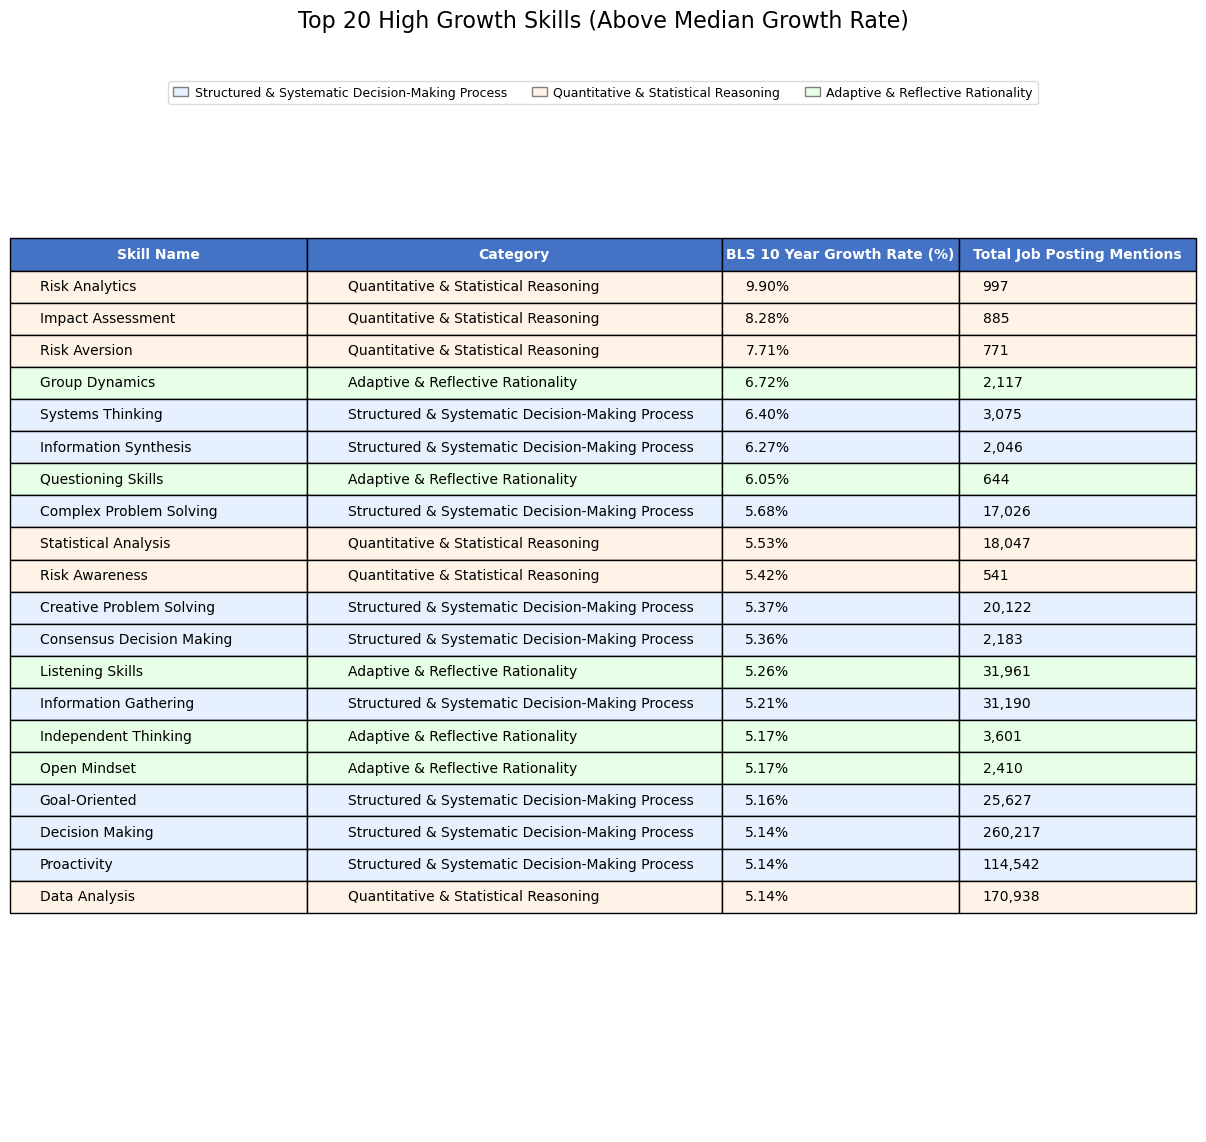

Saved visualization to 'top_20_high_growth_skills.png'


<Figure size 640x480 with 0 Axes>

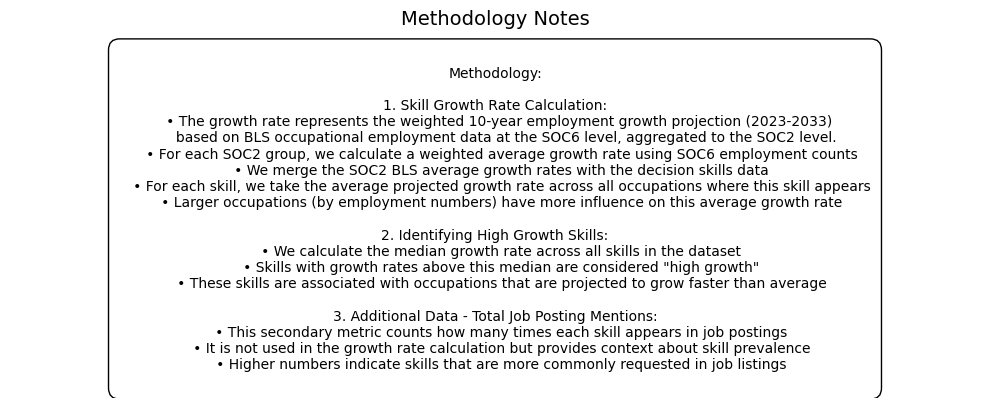

In [ ]:
## Occupatiuon growth rate and decision skills

# Calculate median growth rate
median_growth = skill_growth[pct_change_col].median()
print(f"Median growth rate across all skills: {median_growth:.2f}%")

# Identify high growth skills (above median growth)
high_growth_skills = skill_growth[skill_growth[pct_change_col] >= median_growth].copy()
high_growth_skills = high_growth_skills.sort_values(pct_change_col, ascending=False)

print(f"Found {len(high_growth_skills)} high growth skills (above median {median_growth:.2f}%)")

# Save all skills with their growth rates to CSV
skill_growth.to_csv('all_skills_growth_rates.csv', index=False)

# Save just the high growth skills to a separate CSV
high_growth_skills.to_csv('high_growth_skills.csv', index=False)

print(f"Saved growth rate data to CSV files: 'all_skills_growth_rates.csv' and 'high_growth_skills.csv'")

# Get only top 20 skills
top_20_skills = high_growth_skills.head(20)

# Create a figure with reduced dimensions and whitespace
fig, ax = plt.subplots(figsize=(12, 12))  # Fixed size for top 20 skills
ax.axis('off')

# Define color scheme for categories
category_colors = {
    'Structured & Systematic Decision-Making Process': '#E6F0FF',  # Light blue
    'Quantitative & Statistical Reasoning': '#FFF2E6',  # Light orange
    'Adaptive & Reflective Rationality': '#E6FFE6'   # Light green
}

# Format data for the table
table_data = []
cell_colors = []
for _, row in top_20_skills.iterrows():
    table_data.append([
        row[skill_col],
        row[category_col],
        f"{row[pct_change_col]:.2f}%",
        f"{int(row['Total_Skill_Mentions']):,}"
    ])
    
    # Get color for this category
    category = row[category_col]
    color = category_colors.get(category, 'white')
    cell_colors.append([color, color, color, color])

# Create the table with color coding - move it higher in the figure
table = plt.table(
    cellText=table_data,
    colLabels=['Skill Name', 'Category', 'BLS 10 Year Growth Rate (%)', 'Total Job Posting Mentions'],
    loc='center',
    cellLoc='left',
    colWidths=[0.25, 0.35, 0.20, 0.20],
    cellColours=cell_colors
)

# Color the header row
for j in range(4):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)  # Slightly larger font
table.scale(1, 1.6)  # Slightly more spacing between rows for readability

# Add a title closer to the top of the chart
plt.title('Top 20 High Growth Skills (Above Median Growth Rate)', 
          fontsize=16, y=0.98, pad=10)

# Create a legend for category colors - horizontal with 3 columns
legend_elements = []
for category, color in category_colors.items():
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='gray', 
                                        label=category))

# Add legend horizontally at the top with minimal spacing
plt.legend(handles=legend_elements, loc='upper center', 
          bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=9,
          frameon=True, framealpha=0.7, handlelength=1.2, handletextpad=0.5)

# Use tight layout to minimize whitespace
plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.95])

# Display the table
plt.show()

# Save the table as an image with minimal whitespace
plt.savefig('top_20_high_growth_skills.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'top_20_high_growth_skills.png'")

# Create a separate figure for the methodology
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

methodology_text = """
Methodology:

1. Skill Growth Rate Calculation:
   • The growth rate represents the weighted 10-year employment growth projection (2023-2033) 
     based on BLS occupational employment data at the SOC6 level, aggregated to the SOC2 level.
   • For each SOC2 group, we calculate a weighted average growth rate using SOC6 employment counts
   • We merge the SOC2 BLS average growth rates with the decision skills data
   • We filter out small samples, skills need to appear in at least 500 postings to be included in the analysis
   • Larger occupations (by employment numbers) have more influence on this average growth rate

2. Identifying High Growth Skills:
   • We calculate the median growth rate across all skills in the dataset
   • Skills with growth rates above this median are considered "high growth"
   • These skills are associated with occupations that are projected to grow faster than average

3. Additional Data - Total Job Posting Mentions:
   • This secondary metric counts how many times each skill appears in job postings
   • It is not used in the growth rate calculation but provides context about skill prevalence
   • Higher numbers indicate skills that are more commonly requested in job listings
"""

# Add methodology text with better formatting
plt.text(0.5, 0.5, methodology_text, fontsize=10, 
         va='center', ha='center', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8'),
         transform=ax.transAxes)

plt.title('Methodology Notes', fontsize=14, pad=35)
plt.tight_layout()
plt.savefig('improved_methodology_notes.png', dpi=300, bbox_inches='tight')


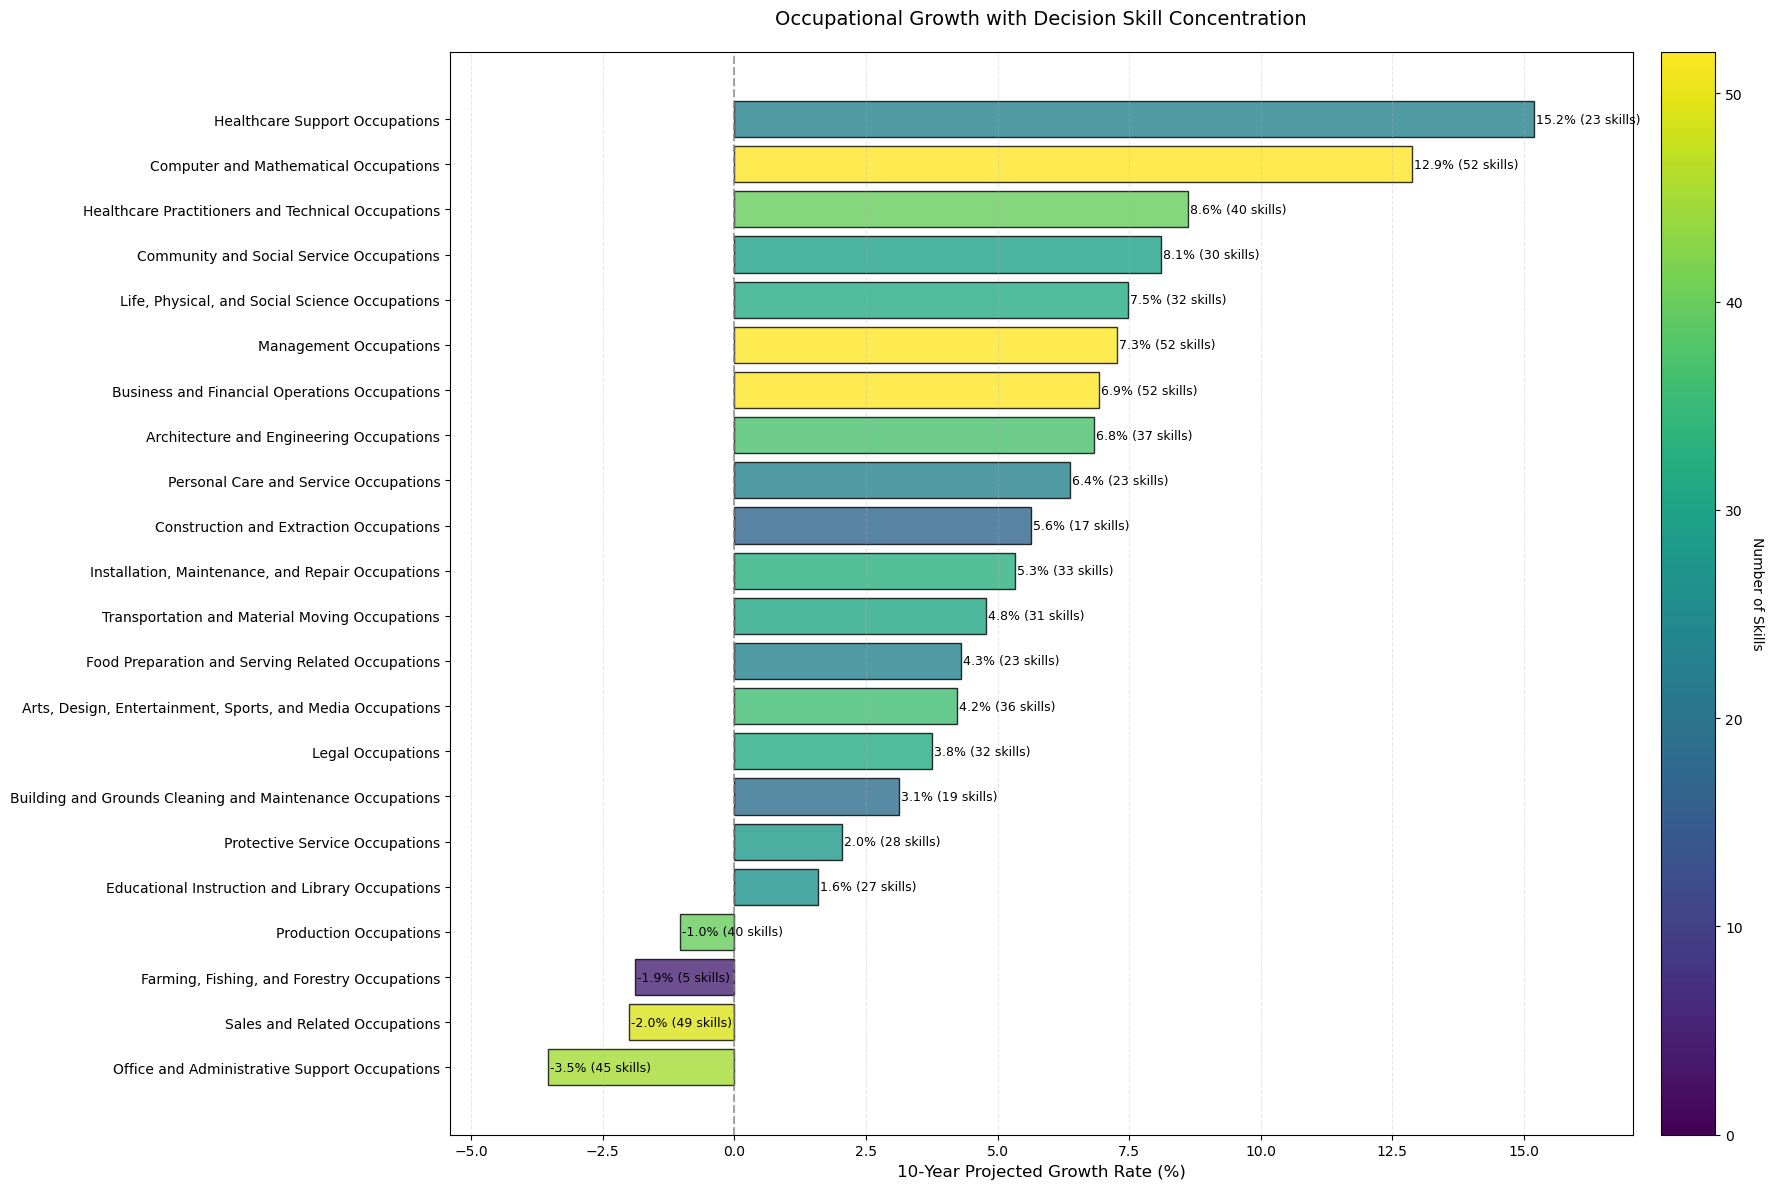

<Figure size 640x480 with 0 Axes>

In [209]:
# Simplified decision skills growth visualization

# 1. Sort all occupations by growth rate (descending)
sorted_occupations = (
    bls_soc2_data
    .sort_values('weighted_10yr_growth_pct', ascending=False)
    .copy()
)

# 2. Count **all** (decision) skills per occupation
skill_concentration = (
    merged_data
    .groupby('soc2_name')
    .agg({'SKILL_NAME': 'nunique'})
    .reset_index()
    .rename(columns={'SKILL_NAME': 'skill_count'})
)

# 3. Merge and fill NaNs
sorted_occupations = (
    sorted_occupations
    .merge(skill_concentration, on='soc2_name', how='left')
    .fillna({'skill_count': 0})
)
sorted_occupations['skill_count'] = sorted_occupations['skill_count'].astype(int)

# 4. Plot
fig, ax = plt.subplots(figsize=(16, 12))

# color by skill_count
max_skills = sorted_occupations['skill_count'].max()
norm       = plt.Normalize(0, max_skills)
colors     = plt.cm.viridis(norm(sorted_occupations['skill_count']))

bars = ax.barh(
    sorted_occupations['soc2_name'],
    sorted_occupations['weighted_10yr_growth_pct'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)

# 5. Invert so the fastest‑growing sit at the top
ax.invert_yaxis()

# 6. Pad x‑limits for label room
g_min, g_max = sorted_occupations['weighted_10yr_growth_pct'].min(), sorted_occupations['weighted_10yr_growth_pct'].max()
pad = (g_max - g_min) * 0.1
ax.set_xlim(g_min - pad, g_max + pad)

# 7. Annotate outside each bar
for bar, growth, count in zip(
    bars,
    sorted_occupations['weighted_10yr_growth_pct'],
    sorted_occupations['skill_count']
):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    ax.text(
        x + pad*0.02, y,
        f"{growth:.1f}% ({count} skills)",
        va='center', ha='left',
        fontsize=9, clip_on=False
    )

# 8. Styling
ax.axvline(0, color='gray', linestyle='--', alpha=0.7)
ax.set_title('Occupational Growth with Decision Skill Concentration', fontsize=14, pad=20)
ax.set_xlabel('10‑Year Projected Growth Rate (%)', fontsize=12)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# 9. Colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Number of Skills', rotation=270, labelpad=15)

plt.tight_layout()
plt.subplots_adjust(left=0.10) 
plt.show()

# 10. Save
plt.savefig('soc2_growth_with_skill_counts.png', dpi=300, bbox_inches='tight')

In [210]:
# Export the raw data to Excel
sorted_occupations[['soc2_name', 'weighted_10yr_growth_pct', 'skill_count']].to_excel('occupation_growth_skills.xlsx', index=False)

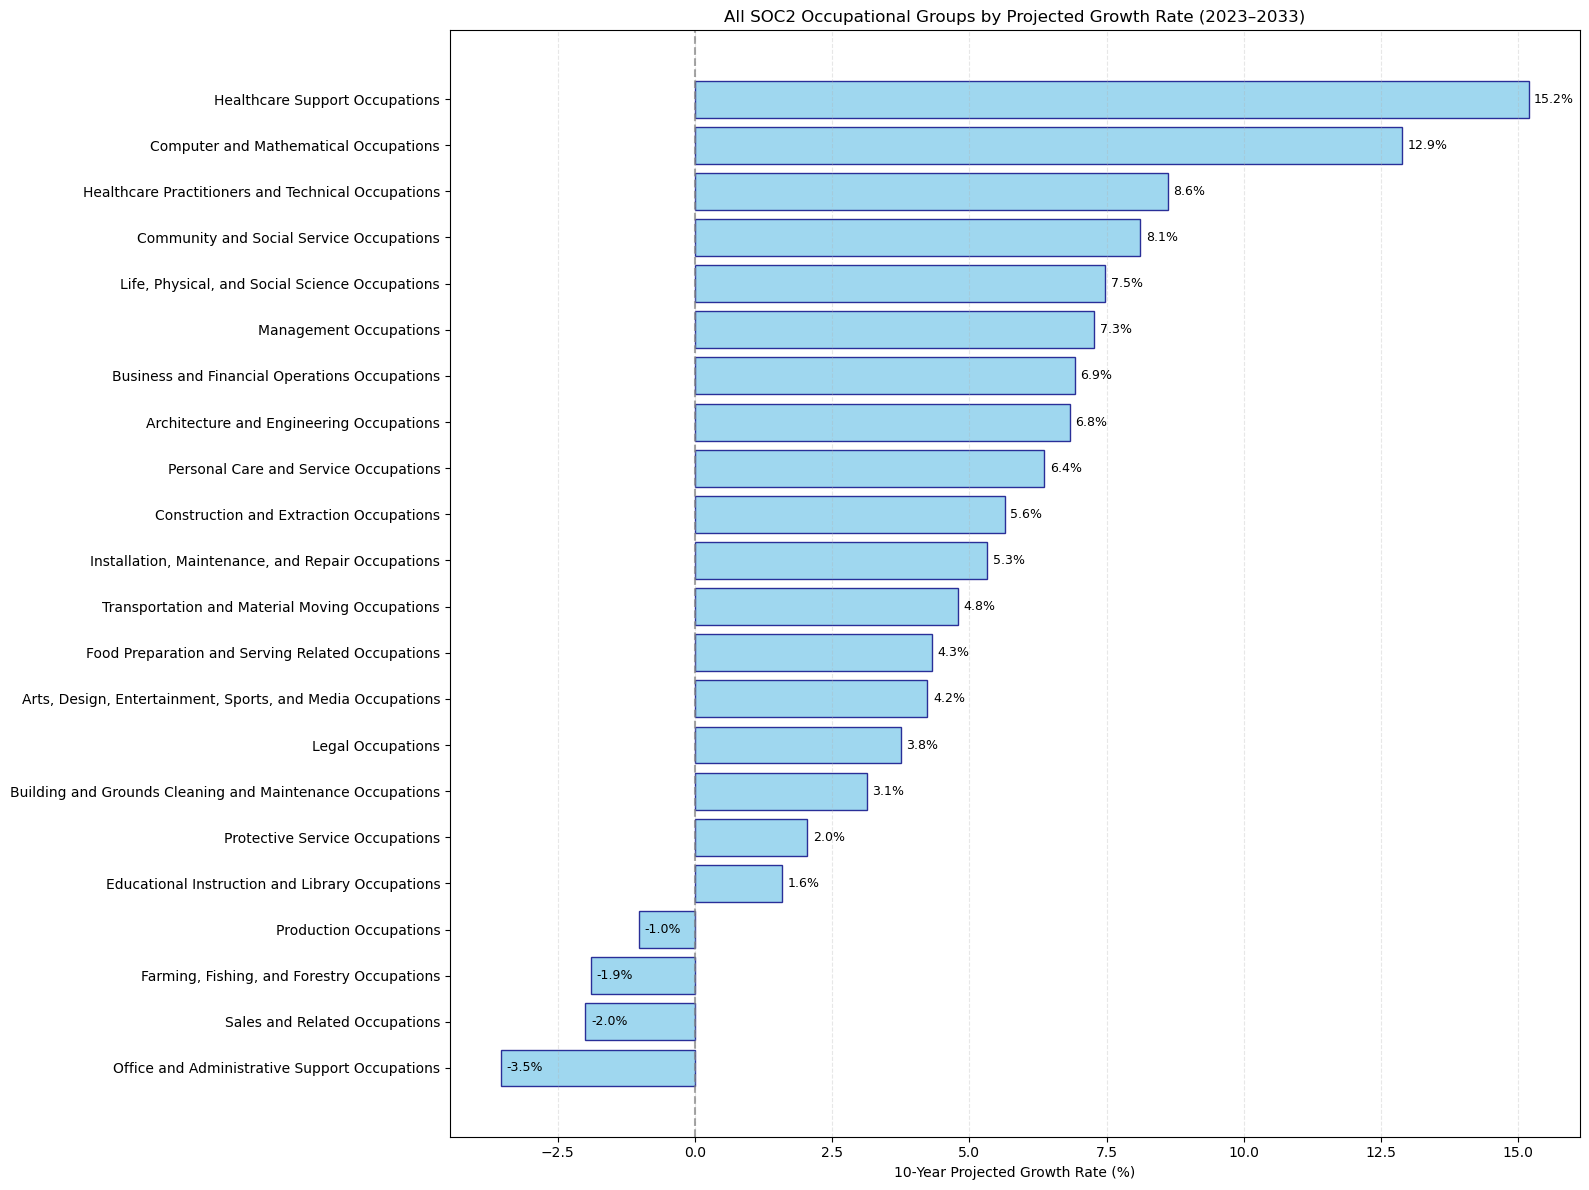

<Figure size 640x480 with 0 Axes>

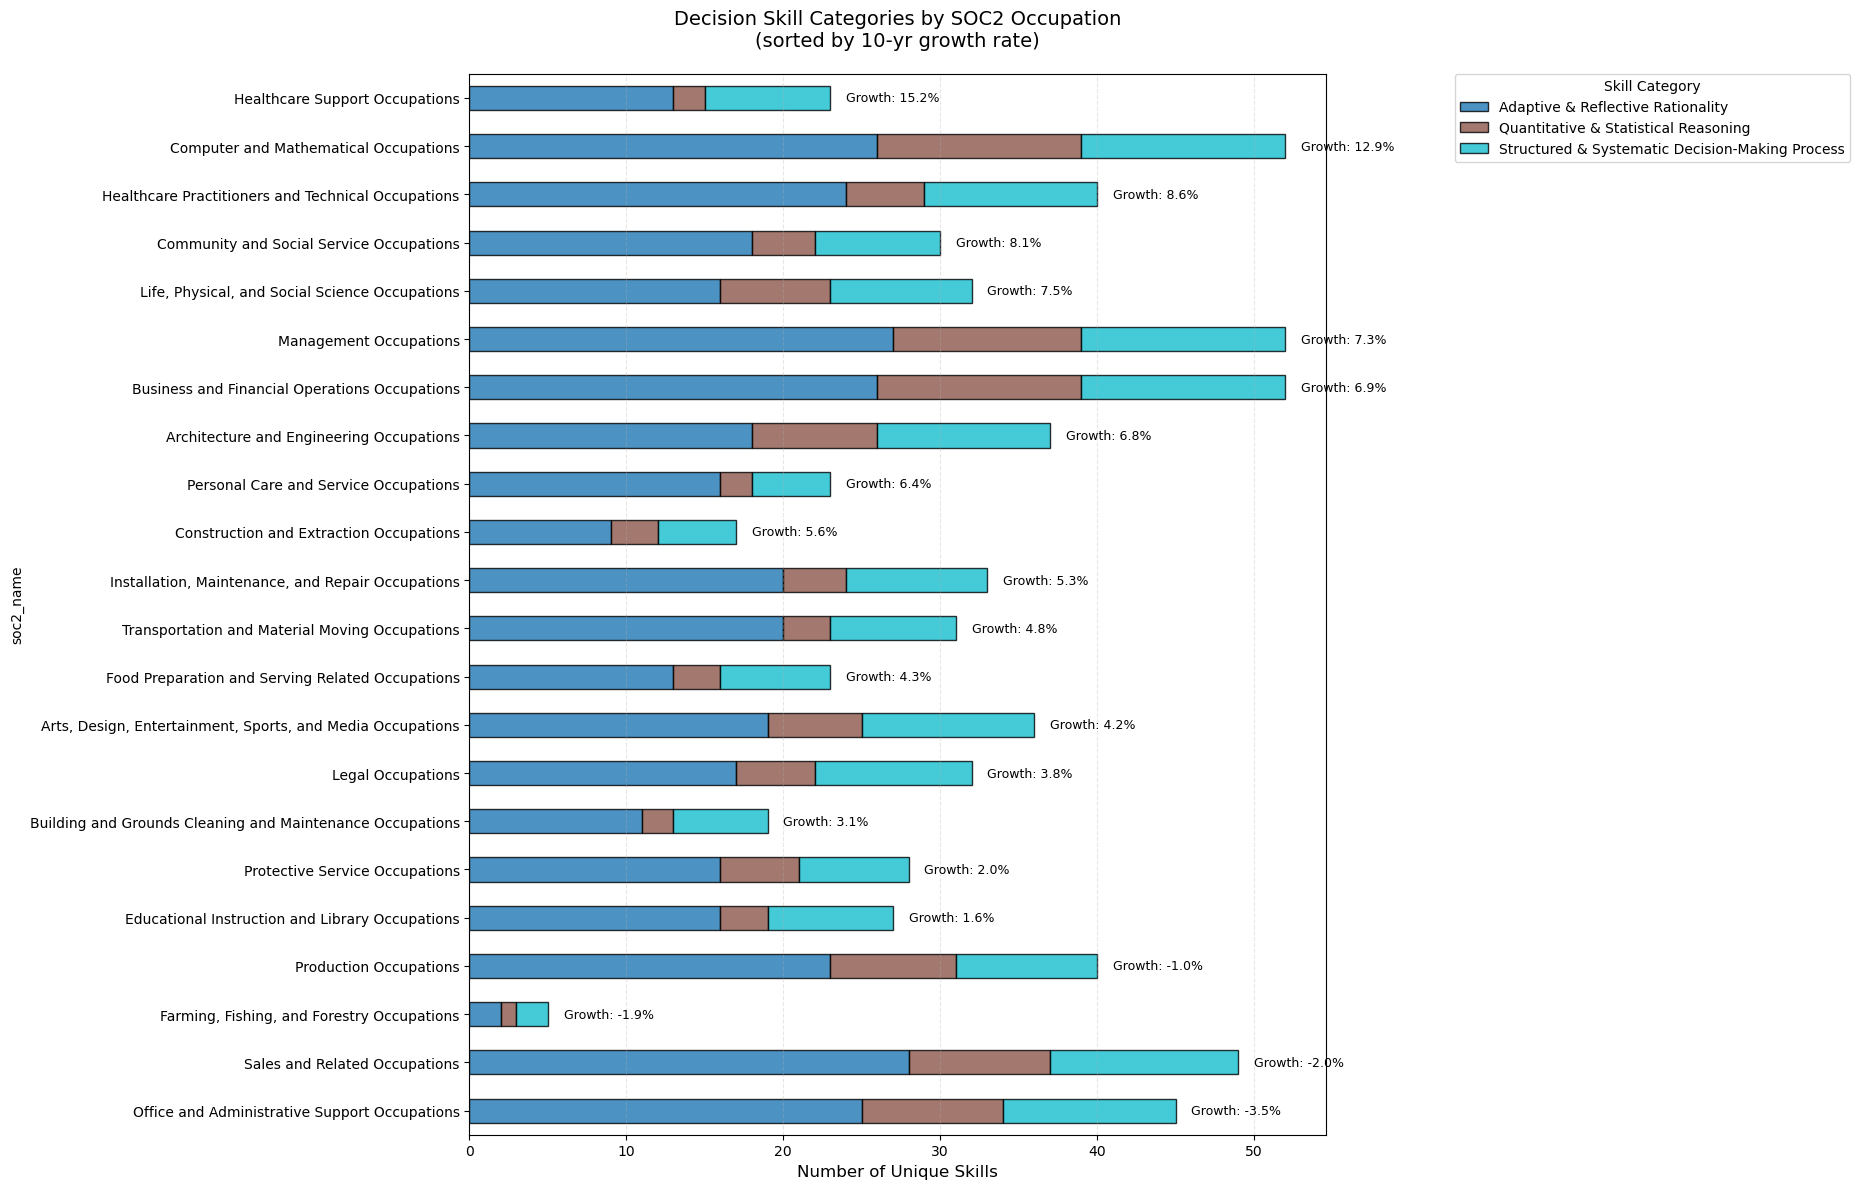

<Figure size 640x480 with 0 Axes>

In [211]:
# 1. Bar chart of all SOC2 occupations by growth rate only
all_soc2_occupations = bls_soc2_data.sort_values('weighted_10yr_growth_pct', ascending=True)

plt.figure(figsize=(16, 12))
bars = plt.barh(
    all_soc2_occupations['soc2_name'],
    all_soc2_occupations['weighted_10yr_growth_pct'],
    color='skyblue', edgecolor='navy', alpha=0.8
)
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
for i, bar in enumerate(bars):
    g = all_soc2_occupations['weighted_10yr_growth_pct'].iloc[i]
    plt.text(g + 0.1, i, f"{g:.1f}%", va='center', fontsize=9)

plt.title('All SOC2 Occupational Groups by Projected Growth Rate (2023–2033)')
plt.xlabel('10‑Year Projected Growth Rate (%)')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
plt.savefig('all_soc2_occupations_by_growth.png', dpi=300, bbox_inches='tight')

# 3. Stacked bar chart of unique skill‐category composition by occupation
category_counts = (
    merged_data
    .groupby(['soc2_name','SKILL_CATEGORY'])['SKILL_NAME']
    .nunique()
    .unstack(fill_value=0)
)

category_data = (
    category_counts
    .reset_index()
    .merge(
        bls_soc2_data[['soc2_name','weighted_10yr_growth_pct']],
        on='soc2_name', how='left'
    )
    .sort_values('weighted_10yr_growth_pct', ascending=True)
)

# 1) Make figure wider
fig, ax = plt.subplots(figsize=(20, 12))

category_cols = [c for c in category_data.columns
                 if c not in ['soc2_name','weighted_10yr_growth_pct']]

category_data.plot(
    kind='barh',
    x='soc2_name',
    y=category_cols,
    stacked=True,
    ax=ax,
    colormap='tab10',
    edgecolor='black',
    alpha=0.8
)

# Annotate each bar with its growth rate
for i, (_, row) in enumerate(category_data.iterrows()):
    growth = row['weighted_10yr_growth_pct']
    total_skills = row[category_cols].sum()
    ax.text(
        total_skills + 1,
        i,
        f"Growth: {growth:.1f}%",
        va='center',
        fontsize=9
    )

# 2) Move legend outside to the right
ax.legend(
    title='Skill Category',
    loc='upper left',
    bbox_to_anchor=(1.15, 1),   # x > 1 pushes it outside the axes
    borderaxespad=0
)


# Final styling
ax.set_title(
    'Decision Skill Categories by SOC2 Occupation\n(sorted by 10‑yr growth rate)',
    fontsize=14, pad=20
)
ax.set_xlabel('Number of Unique Skills', fontsize=12)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# 3) Give tight_layout a little extra room on the right
plt.tight_layout()              # first let tight_layout do its thing
plt.subplots_adjust(left=0.25)  # increase left margin (0.25 = 25% of figure width)
plt.show()

# Save
plt.savefig('soc2_decision_skill_categories_unique_wide.png', dpi=300, bbox_inches='tight')
